In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter  # loss tracking

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
channels = 3
height, width = 32, 32
n_patches = 4
P = int(32/n_patches)
d_model = 1024
n_heads = 16
n_layers = 12

n_epochs = 30
batch_size = 80 # multiples of 16 only due to dataset size
learning_rate = 0.001
drpoout_rate = 0.2

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='/home/ogomi/AI/ViT/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/ogomi/AI/ViT/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes

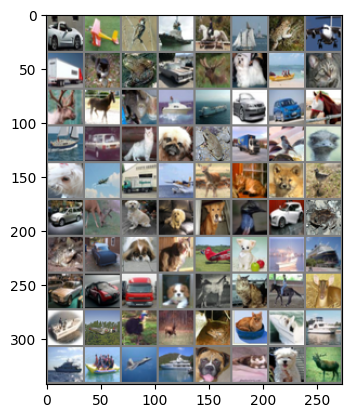

automobile airplane bird  ship  horse ship  frog  airplane truck cat   frog  automobile deer  dog   ship  cat   deer  horse cat   ship  ship  automobile automobile horse ship  automobile cat   dog   frog  truck bird  bird  dog   airplane truck airplane deer  cat   dog   bird  automobile deer  dog   dog   dog   bird  automobile frog  frog  automobile dog   cat   airplane dog   ship  ship  automobile automobile truck dog   horse cat   horse deer  ship  airplane bird  deer  frog  cat   ship  ship  ship  ship  airplane ship  dog   cat   dog   deer 
torch.Size([80, 3, 32, 32])


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(images.shape)

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_chans=3,
                 embed_dim=768,
                 bias=True):
        
        """
        Args:
            img_size: Expected Image Shape (img_size x img_size)
            patch_size: Wanted size for each patch
            in_chans: Number of channels in image (3 for RGB)
            embed_dim: Transformer embedding dimension
        
        """
        super(PatchEmbed, self).__init__()
        assert img_size % patch_size == 0
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.num_patches = (img_size // patch_size)**2
        
        self.proj = nn.Conv2d(in_channels=in_chans,
                              out_channels=embed_dim, 
                              kernel_size=patch_size, 
                              stride=patch_size,
                              bias=bias)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x


class Attention(nn.Module):
    def __init__(self, att_embedding):
        super().__init__()
        self.keys = nn.Linear(d_model, att_embedding, bias=False)
        self.queries = nn.Linear(d_model, att_embedding, bias=False)
        self.values = nn.Linear(d_model, att_embedding, bias=False)

        self.drop = nn.Dropout(drpoout_rate)
    
    def forward(self, input):
        B, T, C = input.shape # C is attention head size

        k = self.keys(input) # (B, T, C)
        q = self.queries(input) # (B, T, C)
        v = self.values(input) # (B, T, C) 

        wei = (q @ k.transpose(dim0=1, dim1=2)) * (C**-0.5) # (B, T, C) @ (B, C, T) = (B, T, T)
        wei = F.softmax(wei, dim=-1)
        wei = self.drop(wei)
        wei = wei @ v # (B, T, T) @ (B, T, C) = (B, T, C)
        return wei


class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.att_heads =nn.ModuleList([Attention(d_model // n_heads) for _ in range(n_heads)]) # n_heads x (B, T, C/n_heads)
        self.linear_projection = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(drpoout_rate)
    
    def forward(self, x):
        x = torch.cat([head(x) for head in self.att_heads], dim=-1) # (B, T, C) cat over channels
        x = self.linear_projection(x)
        
        x = self.dropout(x)
        return x
    

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(drpoout_rate)
        self.relu = nn.GELU()
        self.l2 = nn.Linear(d_model, d_model)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.drop(x)
        out = self.l2(x)
        return out


class Block(nn.Module):
    def __init__(self):
        super().__init__()
        self.lnorm_1 = nn.LayerNorm(d_model)
        self.att = MultiHeadAttention()
        self.lnorm_2 = nn.LayerNorm(d_model)
        self.ffw = FeedForward()

    def forward(self, x):
        x = x + self.att(self.lnorm_1(x))
        x = x + self.ffw(self.lnorm_2(x))
        return x


class ViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.patchAndEmbed = PatchEmbed(height, P, channels, d_model)
        self.pos_embed = nn.Embedding(n_patches * n_patches + 1, d_model)
        self.postion_indexes = torch.tensor([_ for _ in range(n_patches*n_patches+1)]).to(device)
        self.blocks = nn.Sequential(*[Block() for _ in range(n_layers)])
        self.out_mlp = nn.Linear(d_model, len(classes))
        self.output_row = nn.Parameter(torch.rand(1,1,d_model))
        self.out_layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, C, H, W = x.shape # (B, C, H, W) -> cut squares of P x P from channels
        x = self.patchAndEmbed(x) # linear projection image -> patches -> (B, n_patches^2, d_model)
        # add addtitional token for output TODO: does it matter if it is the last or first row ?
        # expanded to be indifferent to examples (each example the same output row, so it can train to be a good output row)
        x = torch.cat([self.output_row.expand(x.shape[0],-1,-1), x], dim=1)
        x = x + self.pos_embed(self.postion_indexes)
        x = self.blocks(x)
        x = self.out_layer_norm(x)
        out = self.out_mlp(x[:, 0, :])
        return out

In [34]:
m = ViT()
model = m.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
writer = SummaryWriter()

75.81185 M parameters


In [ ]:
with torch.no_grad():
    model.eval()
    test_loss = []
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        B, C, H, W = inputs.shape
        logits = m(inputs)
        test_loss.append(F.cross_entropy(logits, labels).item())
    train_loss_avg = sum(test_loss) / len(test_loss)  
    print(f'Initialized network train_loss: {train_loss_avg}')
    model.train()

In [ ]:
def LogGrads(model, epoch):
    with torch.no_grad():
        count = 0
        head_count = 0
        ff_count = 0
        for p in model.parameters():
            layerName: str = ""
            if len(p.shape) == 1: # bias is not ineresting in looking how gradiant passes
                continue
            if p.shape[0] == 64:
                head_count += 1
                if head_count < 46:
                    continue # if not the last head in layer, skip it
                else:
                    layerName = "LastHeadLinear" + str(-(46-head_count))
                    if head_count == 48: # last head in layer we can log to see head gradient norm
                        head_count = 0
            elif p.shape[0] == 1024 and count > 2:
                ff_count += 1
                if ff_count == 1:
                    layerName = "projection"
                else:
                    layerName = "ff"
                if ff_count == 3:
                    ff_count = 0
            if count == 0:
                layerName = "embed"    
            if count == 1:
                layerName = "pos_embed"
            count += 1
            layerName = str(count) + layerName
            writer.add_scalar('Grad_norm/train/layer'+layerName, p.grad.norm() / p.numel(), epoch)
            writer.add_histogram("Grad_dist/train/layer"+layerName, p.grad, global_step=epoch)

In [ ]:
epoch_loss_avg_arr = []
for epoch in range(n_epochs):  # loop over the dataset multiple times
    epoch_loss = []
    print(f"Running epoch: {epoch}")
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        logits = m(inputs)

        loss = F.cross_entropy(logits, labels)
        epoch_loss.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()
    LogGrads(model, epoch)
    epoch_loss_avg = sum(epoch_loss) / len(epoch_loss) 
    epoch_loss_avg_arr.append(epoch_loss_avg)
    writer.add_scalar('Loss/train', epoch_loss_avg, epoch)

    if (epoch % 4 == 0) or (epoch == n_epochs-1):
        model.eval()
        test_loss = []
        for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            B, C, H, W = inputs.shape
            logits = m(inputs)
            test_loss.append(F.cross_entropy(logits, labels).item())
        test_loss_avg = sum(test_loss) / len(test_loss)          
        writer.add_scalar('Loss/test', test_loss_avg, epoch)
        print(f'epoch: {epoch} train_loss: {epoch_loss_avg}, val_loss: {test_loss_avg}')
        model.train()
    
    if epoch > 5:
        if min(epoch_loss_avg_arr[-5:-3]) < (epoch_loss_avg + 0.01):
            print(f"Early stopping on epoch {epoch} due to current loss_avg: {epoch_loss_avg} compared to last 4: {epoch_loss_avg_arr[-5:-1]}")
            break

writer.close()


In [36]:
correct = 0
total = 0
# accuracy check
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        B, C, H, W = images.shape
        logits = m(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    model.train()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 45 %


In [37]:
correct = 0
total = 0
# accuracy check
with torch.no_grad():
    model.eval()
    for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        B, C, H, W = images.shape
        logits = m(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    model.train()

print(f'Accuracy of the network on the 10000 train images: {100 * correct // total} %')

Accuracy of the network on the 10000 train images: 82 %


2 layer bullshit net, 101 epochs, 3M params: </br>
train_loss: 0,3261, train acc: 92 % </br>
val_loss: 8.31, acc: 50 % </br>
 </br>
2 layer bullshit net with dropout, 101 epochs, 3M params: </br>
train_loss: 0,65, train acc: 91 % </br>
val_loss: 4.56, acc: 51 % </br>

Attention alone, 31 epochs, 0.07M params: </br>
train_loss: 1.913, train acc: 31 % </br>
val_loss: 1.88, acc: 31 % </br>

Attention with mlp 3 layers, 31 epochs, 0.26M params: </br>
train_loss: 1.482, train acc: 51 % </br>
val_loss: 1.57, acc: 43 % </br>

MultiHeadAttention 3 layers 8 heads, 128 d_model, 50 epochs, 2.39M params: </br>
train_loss: 1.085, train acc: 82 % </br>
val_loss: 1.748, acc: 45 % </br>

MultiHeadAttention 24 layers 16 heads, 1024 d_model, 50 epochs, 151M params: </br>
train_loss: 1.21, train acc: 53 % </br>
val_loss: 1.22, acc: 51 % </br>

The final version sould be trained for much longer than 50 epochs, but who has time for that</br>
